# Upper Grindelwald case study

### Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

%matplotlib inline
fig_size = 12, 6
plt.rcParams['figure.figsize'] = (fig_size)  # Default plot size
import scipy.stats as stats
import numpy as np
import pandas as pd
import xarray as xr
import os
import shutil
import netCDF4
import salem
import copy
import datetime

import my_colors as mc

import pylab as py

In [2]:
import oggm
from oggm import cfg
from oggm import workflow
from oggm import utils
from oggm import graphics
from oggm.core.models import massbalance, flowline
from oggm.core.preprocessing.inversion import invert_parabolic_bed
from oggm.core.preprocessing.climate import local_mustar_apparent_mb
from oggm.core.preprocessing.inversion import prepare_for_inversion

In [3]:
cfg.initialize()  # read the default parameter file for OGGM
lengths_data = pd.read_csv(utils.get_demo_file('grindelwald_lengths.csv'), index_col=0)

### Init glacier directory

In [4]:
bdir = '/home/thomas/oggm/grindelwald/'
gdir = utils.GlacierDirectory('RGI50-11.01270', base_dir=bdir)

### Moritz' parameters 

In [5]:
glen_a = cfg.A
y_start = 1879
prcp_fac = 1.8

In [6]:
# filepaths
climate_file_path = gdir.get_filepath('climate_monthly')
original_file_path = climate_file_path.replace('climate_monthly.nc', 'climate_monthly_orig.nc')
# replace
ds = xr.open_dataset(original_file_path)
ds['prcp'] = ds.prcp / 2.5 * prcp_fac
if os.path.exists(climate_file_path):
    os.remove(climate_file_path)
ds.to_netcdf(climate_file_path)
# update
local_mustar_apparent_mb(gdir, tstar=1975, bias=0.)
prepare_for_inversion(gdir)
out = invert_parabolic_bed(gdir, glen_a=glen_a, write=True)
# we keep the bed parabolic everywhere, just like for the inversion
cfg.PARAMS['bed_shape'] = 'parabolic'
flowline.init_present_time_glacier(gdir)
# Make it flat
fls = gdir.read_pickle('model_flowlines')
u_fl = copy.deepcopy(fls[0])
u_fl.bed_shape[60] = 7e-4
u_fl.bed_shape[61] = 6e-4
u_fl.bed_shape[62] = 5e-4
u_fl.bed_shape[63] = 4e-4
u_fl.bed_shape[64] = 3e-4
u_fl.bed_shape[65] = 2e-4
u_fl.bed_shape[66:] = 1e-4

In [7]:
# Now we are using "real time", so we have to define the
# starting year accordingly
mb_mod = massbalance.HistalpMassBalanceModel(gdir)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=y_start, 
                                fs=0., glen_a=glen_a)
ref_data = lengths_data.loc[y_start:].copy()
years = ref_data.index.values
length = years * 0.
vol = years * 0.
for i, y in enumerate(years):
    model.run_until(y)
    length[i] = model.length_m
    vol[i] = model.volume_km3

In [8]:
ref_data['oggm'] = length - length[0]

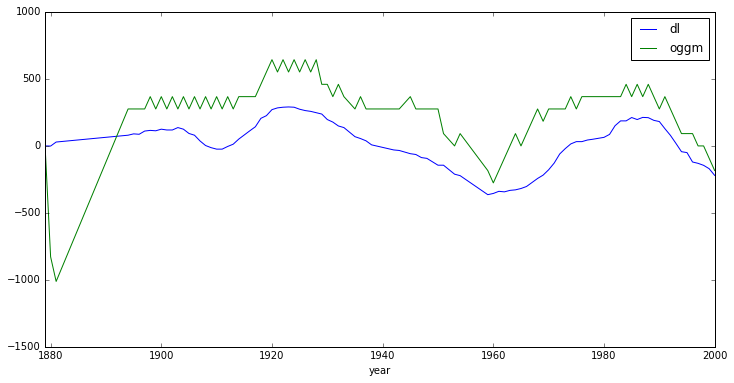

In [9]:
ref_data.plot();

In [10]:
# Biased
mb_mod = massbalance.BiasedMassBalanceModel(gdir)
mb_mod.set_temp_bias(0)
mb_mod.set_prcp_factor(0)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=0, 
                                fs=0., glen_a=glen_a)
years = np.arange(251)
length = years * 0.
vol = years * 0.
for i, y in enumerate(years):
    model.run_until(y)
    length[i] = model.length_m
    vol[i] = model.volume_km3

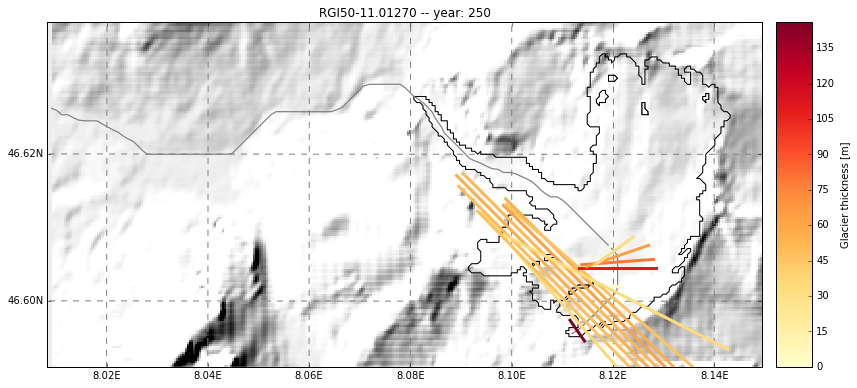

In [11]:
graphics.plot_modeloutput_map(gdir, model=model)

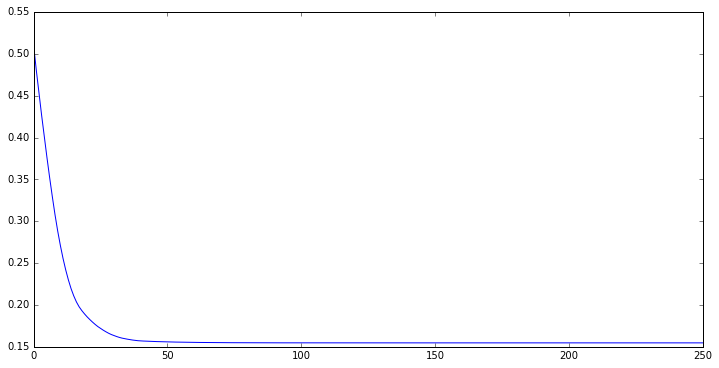

In [12]:
plt.plot(years, vol);

In [13]:
#Define runtime of models and bias set
y_0 = 1.
y_1 = 250.
yrs = np.arange(y_0, y_1+1)
n_years = yrs.size

#length and volume for reference
vol_ref = np.zeros(n_years)
length_ref = np.zeros(n_years)

                      
#Initialize Model and let it run without bias for reference
mb_mod = massbalance.BiasedMassBalanceModel(gdir)
mb_mod.set_prcp_factor(1)
mb_mod.set_temp_bias(0)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=0, 
                                fs=0., glen_a=glen_a)

for i, y in enumerate(yrs):
    model.run_until(y)
    length_ref[i] = model.length_m
    vol_ref[i]= model.volume_km3

    

vol_end_ref = vol_ref[249]
length_end_ref = length_ref[249]


### Output von Längen und Volumsänderung bei versch Bias

In [14]:
#Define runtime of models and bias set
length = np.zeros(n_years)
vol = np.zeros(n_years)
t_bias = [0]
pr_f = [3]

                
mb_mod = massbalance.BiasedMassBalanceModel(gdir)
for b in t_bias:
    mb_mod.set_temp_bias(b)
    for f in pr_f:
        mb_mod.set_prcp_factor(f)
        model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=0, 
                                fs=0., glen_a=glen_a)
        file_name = 'temp_{}_precip_{}.png'.format(b, f)
        for i, y in enumerate(yrs):
            model.run_until(y)
            length[i] = model.length_m
            vol[i]= model.volume_km3
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        ax1.plot(yrs, length);
        ax1.plot(yrs, length_ref, label='Referenz');
        ax1.set_xlabel('Time [Years]')
        ax1.set_ylabel('Length [m]')
        ax1.legend(loc='best')
        ax2.plot(yrs, vol);
        ax2.plot(yrs, vol_ref, label='Referenz');
        ax2.set_xlabel('Years')
        ax2.set_ylabel('Volume [km$^3$]');
        ax2.legend(loc='best')
        plt.savefig('/home/thomas/oggm/grindelwald/plots_sensitivity/' + file_name)
    

ValueError: A value in x_new is above the interpolation range.

### Output von Verhältniskurven

In [14]:
#Define runtime of models and bias set
length = np.zeros(n_years)
vol = np.zeros(n_years)
#t_bias = [0]
t_bias = np.linspace(-9.6, 9.6, 105)
pr_f = [1]
#pr_f = np.linspace(0, 2.8, 61)
a = -1
s_t_bias = np.size(t_bias)
#s_pr_f = np.size(pr_f)


vol_end =  np.zeros(s_t_bias)
length_end = np.zeros(s_t_bias)
                
mb_mod = massbalance.BiasedMassBalanceModel(gdir)

for b in t_bias:
    mb_mod.set_temp_bias(b)
    for f in pr_f:
        a=a+1
        mb_mod.set_prcp_factor(f)
        model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=0, 
                                fs=0., glen_a=glen_a)
        for i, y in enumerate(yrs):
            model.run_until(y)
            length[i] = model.length_m
            vol[i]= model.volume_km3
        vol_end[a] = vol[249]
        length_end[a] =length[249]
        
    #vol_end[a] = vol[249]
    #length_end[a] = length[249]

In [15]:
#Define runtime of models and bias set
length = np.zeros(n_years)
vol = np.zeros(n_years)
t_bias_2 = [0]
#t_bias = np.linspace(-9.6, 9.6, 105)
#pr_f = [1]
pr_f_2 = np.linspace(0, 2.8, 105 )
a = -1
#s_t_bias = np.size(t_bias)
s_pr_f = np.size(pr_f_2)


vol_end_pr =  np.zeros(s_pr_f)
length_end_pr = np.zeros(s_pr_f)
                
mb_mod = massbalance.BiasedMassBalanceModel(gdir)

for b in t_bias_2:
    mb_mod.set_temp_bias(b)
    for f in pr_f_2:
        a=a+1
        mb_mod.set_prcp_factor(f)
        model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=0, 
                                fs=0., glen_a=glen_a)
        for i, y in enumerate(yrs):
            model.run_until(y)
            length[i] = model.length_m
            vol[i]= model.volume_km3
        vol_end_pr[a] = vol[249]
        length_end_pr[a] =length[249]
        
    #vol_end[a] = vol[249]
    #length_end[a] = length[249]

KeyboardInterrupt: 

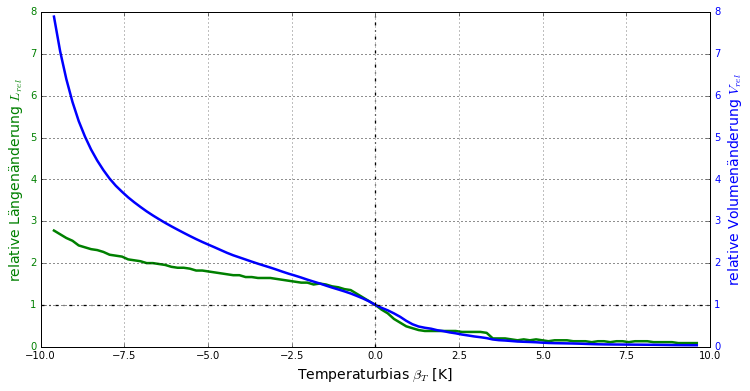

In [81]:
t_bias = np.linspace(-9.6, 9.6, 105)
x_ticks = [-10, -7.5, -5, -2.5, 0, 2.5, 5, 7.5, 10]
vol_end_scale = vol_end/vol_end_ref
length_end_scale = length_end/length_end_ref


fig, ax1 = plt.subplots()
ax1.plot(t_bias, length_end_scale, linewidth=2.5, color= 'green')
ax1.set_xlabel('Temperaturbias $\\beta_T$ [K]', fontsize= 14)
ax1.set_ylim(0, 8)
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('relative Längenänderung $L_{rel}$', fontsize= 14, color='green')
for tl in ax1.get_yticklabels():
    tl.set_color('green')


ax2 = ax1.twinx()
ax2.plot(t_bias, vol_end_scale, linewidth=2.5, color = 'b')
ax2.set_ylabel('relative Volumenänderung $V_{rel}$', fontsize= 14, color='b')
ax2.set_ylim(0, 8)
for tl in ax2.get_yticklabels():
    tl.set_color('b')

#fig, ax = plt.subplots()

plt.gca().yaxis.grid(True)
ax1.grid(True)

#plt.axvline(x=1.,color='k',ls='dashed')
#plt.axhline(y=1.,color='k',ls='dashed')

plt.xticks(x_ticks)
plt.axhline(y=1, color = 'black', linestyle ='dashdot', linewidth=1.3)
plt.axvline(x=0, color= 'black', linestyle ='dashdot', linewidth=1.3)
plt.show()

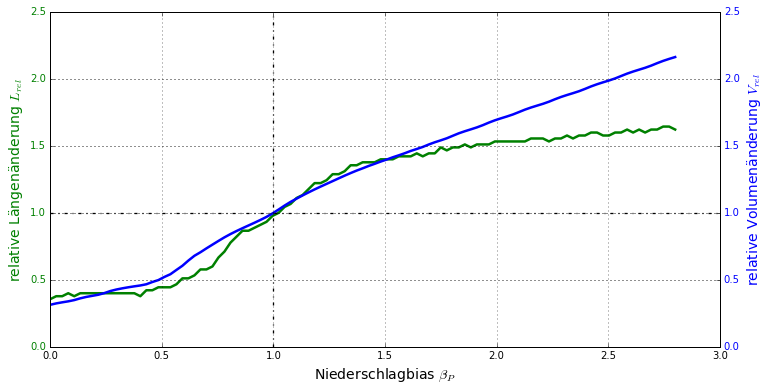

In [82]:
vol_end_scale_pr = vol_end_pr/vol_end_ref
length_end_scale_pr = length_end_pr/length_end_ref


fig, ax1 = plt.subplots()
ax1.plot(pr_f_2, length_end_scale_pr, linewidth=2.5, color= 'green')
ax1.set_xlabel('Niederschlagbias $\\beta_P$', fontsize= 14)
ax1.set_ylim(0, 2.5)

ax1.set_ylabel('relative Längenänderung $L_{rel}$', fontsize= 14, color='green')
for tl in ax1.get_yticklabels():
    tl.set_color('green')


ax2 = ax1.twinx()
ax2.plot(pr_f_2, vol_end_scale_pr, linewidth=2.5, color = 'b')
ax2.set_ylabel('relative Volumenänderung $V_{rel}$', fontsize= 14, color='b')
ax2.set_ylim(0, 2.5)
for tl in ax2.get_yticklabels():
    tl.set_color('b')



plt.gca().yaxis.grid(True)
ax1.grid(True)

#plt.axvline(x=1.,color='k',ls='dashed')
#plt.axhline(y=1.,color='k',ls='dashed')

plt.axhline(y=1, color = 'black', linestyle ='dashdot', linewidth=1.3)
plt.axvline(x=1, color= 'black', linestyle ='dashdot', linewidth=1.3)
plt.show()

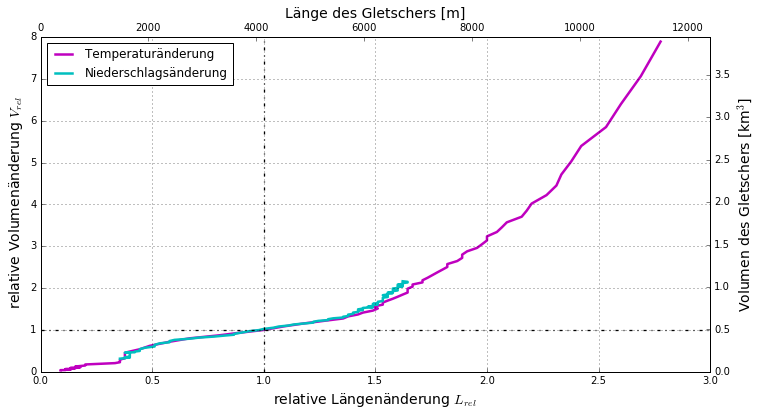

0.493206378924
4140.0


In [101]:
end1 = 3
end2 =end1*length_end_ref

end3 = 8
end4 = end3*vol_end_ref

fig, ax1 = plt.subplots()

ax1.plot(length_end_scale, vol_end_scale, linewidth=2.5, color= 'm', label = 'Temperaturänderung')
ax1.set_xlabel('relative Längenänderung $L_{rel}$', fontsize= 14)
ax1.set_ylim(0, end3)
ax1.set_ylabel(' relative Volumenänderung $V_{rel}$', fontsize= 14)
ax1.set_xlim(0, end1)

ax1.plot(length_end_scale_pr, vol_end_scale_pr, linewidth=2.5, color= 'c', label = 'Niederschlagsänderung')
ax1.legend(loc='best')


plt.gca().yaxis.grid(True)
plt.grid(True)

ax1.axhline(y=1, color = 'black', linestyle ='dashdot', linewidth=1.3)
ax1.axvline(x=1, color= 'black', linestyle ='dashdot', linewidth=1.3)




ax2 = ax1.twiny()
ax2.set_xlabel('Länge des Gletschers [m]', fontsize = 14)
ax2.set_xlim(0,end2)




ax3 = ax1.twinx()
ax3.set_ylabel('Volumen des Gletschers [km$^3$]', fontsize= 14)
ax3.set_ylim(0, end4)
plt.show()

print(vol_end_ref)
print(length_end_ref)

In [123]:
mb_mod = massbalance.BiasedMassBalanceModel(gdir)
mb_mod.set_temp_bias(-9.62)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=0, 
                                fs=0., glen_a=glen_a)
model.run_until_equilibrium()
fl = model.fls[0]

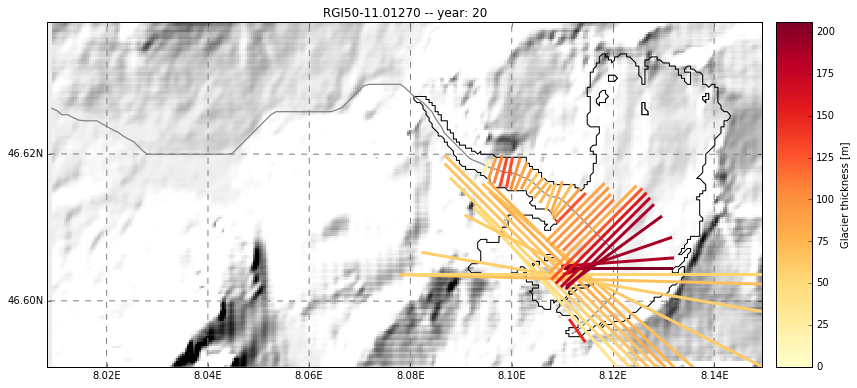

In [122]:
graphics.plot_modeloutput_map(gdir, model=model)

In [34]:
widths = fl.widths_m
length_end_grid = length_end /100
length_end_grid_int = length_end_grid.astype(int)
length_end_grid_deci = length_end_grid - length_end_grid_int

width_at_length_end = np.zeros(np.size(length_end))

j=0
for i in length_end_grid_int:
    width_at_length_end[j] = widths[i] - (widths[i] - widths[i+1])*length_end_grid_deci[j]
    j = j+1

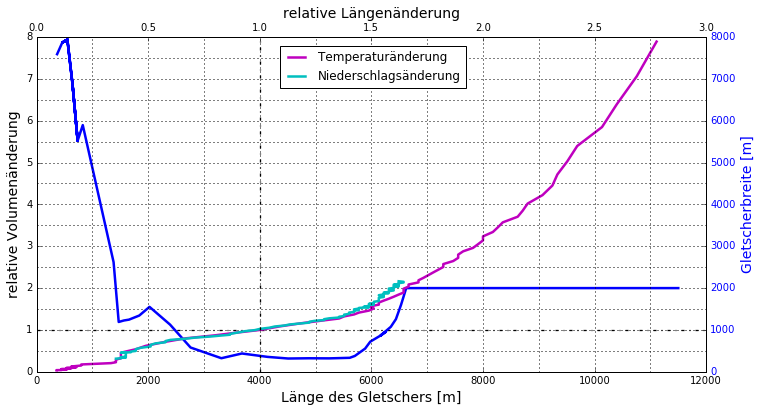

In [64]:
end1 = 3
end2 =end1*length_end_ref

fig, ax1 = plt.subplots()
#ax1.plot(length_end, vol_end, linewidth=2.5, color= 'm', label = 'Temperaturänderung')
#ax1.plot(length_end_pr, vol_end_pr, linewidth=2.5, color= 'c', label = 'Niederschlagsänderung')
ax1.set_xlabel('Länge des Gletschers [m]', fontsize = 14)
ax1.set_ylabel('relative Volumenänderung', fontsize= 14)
ax1.set_xlim(0,end2)
#ax1.set_ylim(0,4)

ax2 = ax1.twinx()
ax2.plot(length_end, width_at_length_end, linewidth=2.5, color = 'b', label = 'Gletscherbreite')
ax2.set_ylabel('Gletscherbreite [m]', fontsize= 14, color='b')

for tl in ax2.get_yticklabels():
    tl.set_color('b')

ax3 = ax1.twiny()
ax3.plot(length_end_scale, vol_end_scale, linewidth=2.5, color= 'm', label = 'Temperaturänderung')
ax3.plot(length_end_scale_pr, vol_end_scale_pr, linewidth=2.5, color= 'c', label = 'Niederschlagsänderung')
ax3.set_xlim(0, end1)
ax3.set_xlabel('relative Längenänderung', fontsize= 14)






ax1.axhline(y=1, color = 'black', linestyle ='dashdot', linewidth=1.3)
ax3.axvline(x= 1, color= 'black', linestyle ='dashdot', linewidth=1.3)

for i in range(16):
    ax3.axvline(x=i/4, color='black', linestyle = 'dotted')
    ax1.axhline(y= i/2, color = 'black', linestyle = 'dotted')
    
#plt.legend(bbox_to_anchor=(1.35, 1.019))
#plt.legend(bbox_to_anchor=(0.287, 1.25))
#plt.legend(bbox_to_anchor=(0.287, -0.1))
plt.legend(bbox_to_anchor=(0.65, 0.99))
plt.show()

In [53]:
mb_mod = massbalance.BiasedMassBalanceModel(gdir)
mb_mod.set_temp_bias(-9.62)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=0, 
                                fs=0., glen_a=glen_a)
model.run_until_equilibrium()
fl = model.fls[0]


In [48]:
h=100
widths_2 = (4*h)/fl.bed_shape
widths = np.sqrt(widths_2)
length_end_grid = length_end /100
length_end_grid_int = length_end_grid.astype(int)
length_end_grid_deci = length_end_grid - length_end_grid_int

width_at_length_end = np.zeros(np.size(length_end))

j=0
for i in length_end_grid_int:
    width_at_length_end[j] = widths[i] - (widths[i] - widths[i+1])*length_end_grid_deci[j]
    j = j+1

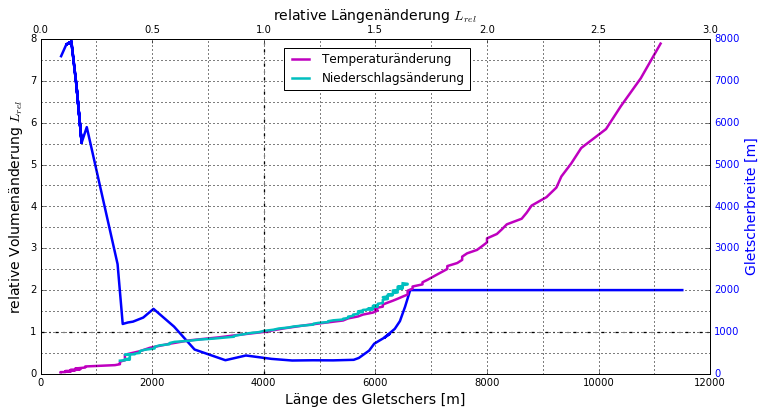

In [99]:
end1 = 3
end2 = end1*length_end_ref

end3 = 8
end4 = end3 * vol_end_ref

fig, ax1 = plt.subplots()

ax1.set_xlabel('Länge des Gletschers [m]', fontsize = 14)
ax1.set_ylabel('relative Volumenänderung $L_{rel}$', fontsize= 14)
ax1.set_xlim(0,end2)
#ax1.set_ylim(0,4)

ax2 = ax1.twinx()
ax2.plot(length_end, width_at_length_end, linewidth=2.5, color = 'b', label = 'Gletscherbreite')
ax2.set_ylabel('Gletscherbreite [m]', fontsize= 14, color='b')

for tl in ax2.get_yticklabels():
    tl.set_color('b')

ax3 = ax1.twiny()
ax3.plot(length_end_scale, vol_end_scale, linewidth=2.5, color= 'm', label = 'Temperaturänderung')
ax3.plot(length_end_scale_pr, vol_end_scale_pr, linewidth=2.5, color= 'c', label = 'Niederschlagsänderung')
ax3.set_xlim(0, end1)
ax3.set_xlabel('relative Längenänderung $L_{rel}$', fontsize= 14)


ax1.axhline(y=1, color = 'black', linestyle ='dashdot', linewidth=1.3)
ax3.axvline(x= 1, color= 'black', linestyle ='dashdot', linewidth=1.3)

for i in range(16):
    ax3.axvline(x=i/4, color='black', linestyle = 'dotted')
    ax1.axhline(y= i/2, color = 'black', linestyle = 'dotted')
    
#plt.legend(bbox_to_anchor=(1.35, 1.019))
#plt.legend(bbox_to_anchor=(0.287, 1.25))
#plt.legend(bbox_to_anchor=(0.287, -0.1))
plt.legend(bbox_to_anchor=(0.65, 0.99))
plt.show()

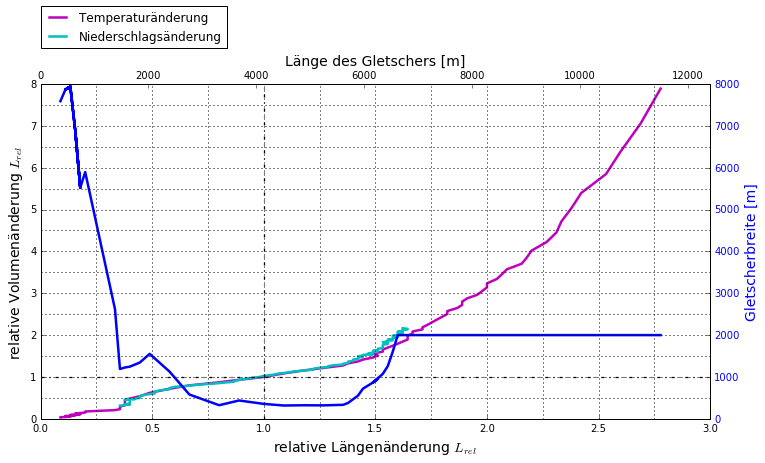

In [120]:
end1 = 3
end2 = end1*length_end_ref

end3 = 8
end4 = end3 * vol_end_ref

fig, ax1 = plt.subplots()

ax1.plot(length_end_scale, vol_end_scale, linewidth=2.5, color= 'm', label = 'Temperaturänderung')
ax1.plot(length_end_scale_pr, vol_end_scale_pr, linewidth=2.5, color= 'c', label = 'Niederschlagsänderung')

ax1.set_xlabel('relative Längenänderung $L_{rel}$', fontsize= 14)
ax1.set_xlim(0, end1)
ax1.set_ylabel('relative Volumenänderung $L_{rel}$', fontsize= 14)
ax1.set_ylim(0, end3)


ax2 = ax1.twinx()
ax2.plot(length_end_scale, width_at_length_end, linewidth=2.5, color = 'b')
ax2.set_ylabel('Gletscherbreite [m]', fontsize= 14, color='b')

for tl in ax2.get_yticklabels():
    tl.set_color('b')

    
ax3 = ax1.twiny()
ax3.set_xlabel('Länge des Gletschers [m]', fontsize = 14)
ax3.set_xlim(0, end2)



ax1.axhline(y=1, color = 'black', linestyle ='dashdot', linewidth=1.3)
ax1.axvline(x= 1, color= 'black', linestyle ='dashdot', linewidth=1.3)

for i in range(16):
    ax1.axvline(x=i/4, color='black', linestyle = 'dotted')
    ax3.axhline(y= i/2, color = 'black', linestyle = 'dotted')
  

#ax1.legend(bbox_to_anchor=(1.35, 1.019))
ax1.legend(bbox_to_anchor=(0.287, 1.25))
#ax1.legend(bbox_to_anchor=(0.287, -0.1))
#ax1.legend(bbox_to_anchor=(0.65, 0.99))
plt.show()

## Random Climate

In this part i will use a climate that changes ranodmly over time. I will use a gaussian normal deviation for both precipitation and temperature.

In [11]:
#Get the runtime until equilibrium of the model
y_0 = 1.

                      
#Initialize Model and let it run without bias for reference
mb_mod = massbalance.BiasedMassBalanceModel(gdir)
mb_mod.set_prcp_factor(1)
mb_mod.set_temp_bias(0)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=0, 
                                fs=0., glen_a=glen_a)

    
model.run_until_equilibrium()
runtime_eq = model.yr
vol_eq = model.volume_km3
length_eq = model.length_m

In [12]:
#Define a random climate
nyrs = 1000
mean_t = 0
sigma_t = 1
bias_t = np.random.normal(mean_t, sigma_t, nyrs)

mean_p = 1
sigma_p = 0.3
bias_p = np.random.normal(mean_p, sigma_p, nyrs)


length = np.zeros(nyrs)
vol = np.zeros(nyrs)
tau = np.zeros(nyrs)

for i in range(0, nyrs):
    t_bias = bias_t[i]
    p_bias = bias_p[i]
    mb_mod.set_temp_bias(t_bias)
    mb_mod.set_prcp_factor(p_bias)
    model.run_until(i + runtime_eq)
    length[i] = model.length_m
    vol[i] = model.volume_km3
    tau[i] = model.yr

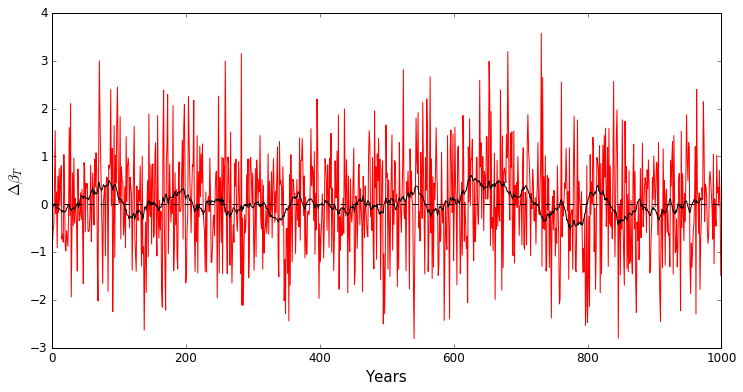

In [13]:
N = 30
mean_30_t = np.convolve(bias_t, np.ones((N,))/N, mode='valid')

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
plt.plot(bias_t, 'r')
plt.plot(mean_30_t, color='black')
plt.ylabel('$\Delta \\beta_T$', fontsize=15)
plt.xlabel('Years', fontsize=15)
plt.axhline(y= 0, color= 'black', ls='dashed')



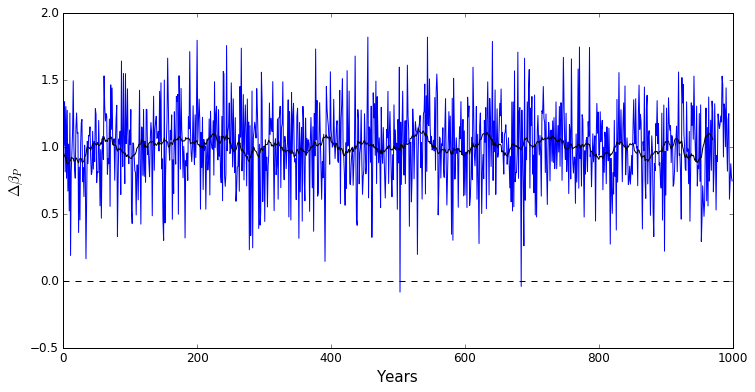

In [14]:
N = 30
mean_30_p = np.convolve(bias_p, np.ones((N,))/N, mode='valid')

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
plt.plot(bias_p, 'b')
plt.plot(mean_30_p, color='black')
plt.ylabel('$\Delta \\beta_P$', fontsize=15)
plt.xlabel('Years', fontsize=15)
plt.axhline(y= 0, color= 'black', ls='dashed')



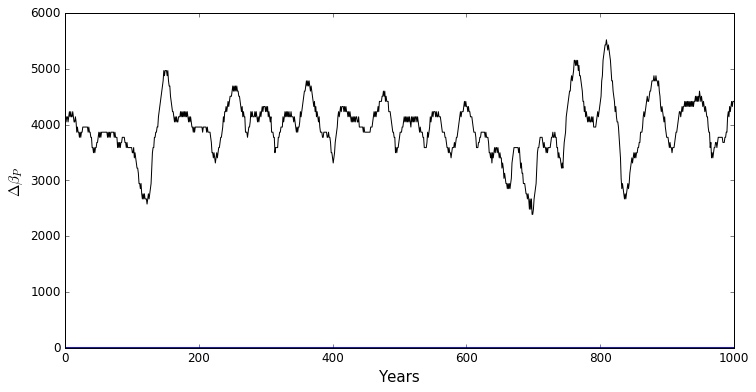

In [15]:
plt.plot(vol)
plt.xlabel('Years')
plt.axhline(y= vol_eq,color='k',ls='dashed')


matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
plt.plot(vol, 'b')
plt.plot(length, color='black')
plt.ylabel('$\Delta \\beta_P$', fontsize=15)
plt.xlabel('Years', fontsize=15)
plt.axhline(y= 0, color= 'black', ls='dashed')



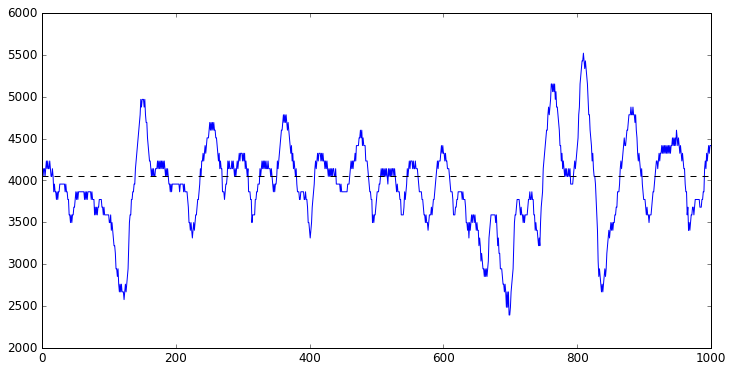

In [16]:
plt.plot(length)
plt.axhline(y= length_eq,color='k',ls='dashed')

### Compare Random Climate to real Climate

In [17]:
# open climate file
d = xr.open_dataset(gdir.get_filepath('climate_monthly'))

In [18]:
#getting temp and prcp out of climate file
annual_temp = d.temp.resample(freq='AS', dim='time', how=np.mean).to_series()
annual_prcp = d.prcp.resample(freq='AS', dim='time', how=np.mean).to_series()
#Getting the climate as array to better handle ist
annual_tlist = annual_temp.as_matrix(columns=None)
annual_plist = annual_prcp.as_matrix(columns=None)

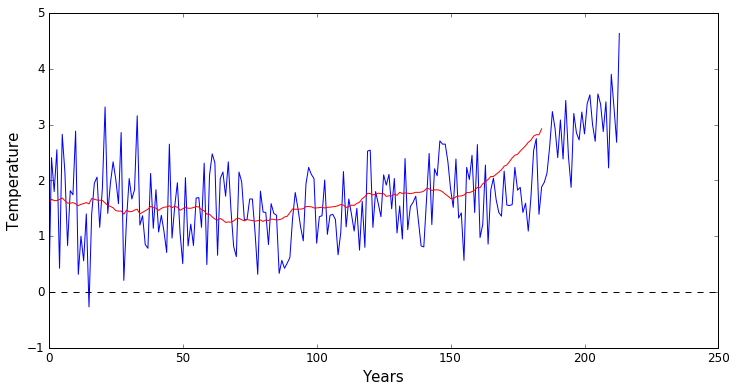

In [19]:
N = 30
mean_30_temp = np.convolve(annual_tlist, np.ones((N,))/N, mode='valid')


matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
plt.plot(annual_tlist, 'b')
plt.plot(mean_30_temp, 'r')
plt.ylabel('Temperature', fontsize=15)
plt.xlabel('Years', fontsize=15)
plt.axhline(y= 0, color= 'black', ls='dashed')


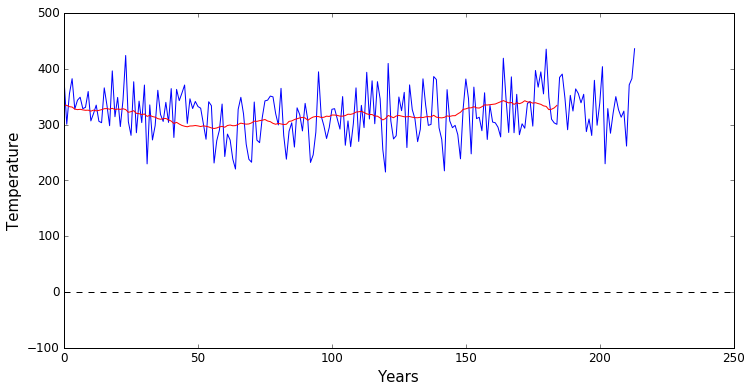

In [20]:
N = 30
mean_30_prcp = np.convolve(annual_plist, np.ones((N,))/N, mode='valid')


matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
plt.plot(annual_plist, 'b')
plt.plot(mean_30_prcp, 'r')
plt.ylabel('Temperature', fontsize=15)
plt.xlabel('Years', fontsize=15)
plt.axhline(y= 0, color= 'black', ls='dashed')


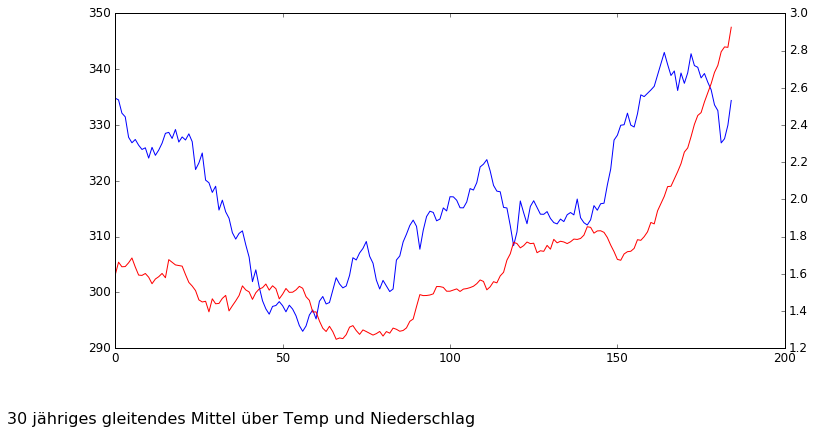

In [21]:
N = 30
mean_10_prcp = np.convolve(annual_plist, np.ones((N,))/N, mode='valid')
mean_10_tmp = np.convolve(annual_tlist, np.ones((N,))/N, mode='valid')

fig, ax1 = plt.subplots()
ax1.plot(mean_10_prcp, color='blue')
ax2 = ax1.twinx()
ax2.plot(mean_10_tmp, color='red')
fig.text(0, -0.05, r'''30 jähriges gleitendes Mittel über Temp und Niederschlag ''', fontsize=16)

First we check what the maximum difference in temp and prcp between two following years is.

In [22]:
yrs = np.size(annual_tlist)-1
d_temp = np.zeros(yrs)
d_prcp = np.zeros(yrs)

for i in range(yrs):
    d_temp[i] = annual_tlist[i+1] - annual_tlist[i]
    d_prcp[i] = annual_plist[i+1] - annual_plist[i]

Durchschnittliche Abweichung 0.0219115501558
Maximale Abweichung: 2.44166660309
Standardabweichung: 0.880528930784


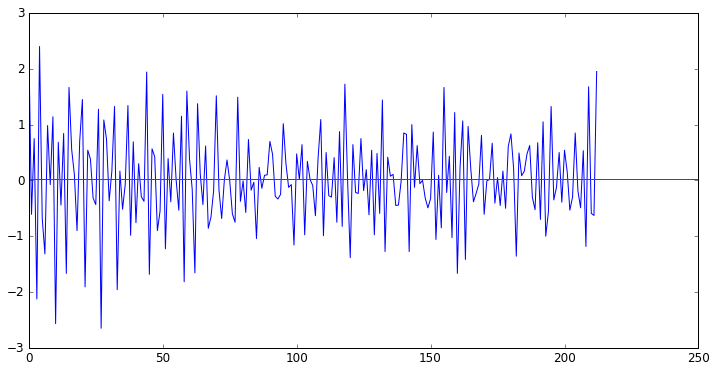

In [23]:
#Plotting difference between the temp of two years
mean_d_temp = np.mean(d_temp)
plt.plot(d_temp)
plt.axhline(y= mean_d_temp, color= 'r')
#Calculating and printing the max, mean and standard deviation of the difference of temp between two years
print('Durchschnittliche Abweichung', mean_d_temp)
max_d_temp = np.amax(d_temp)
print('Maximale Abweichung:',max_d_temp)
std_d_temp = np.std(d_temp)
print('Standardabweichung:', std_d_temp)

NameError: name 'mean_d_prcp' is not defined

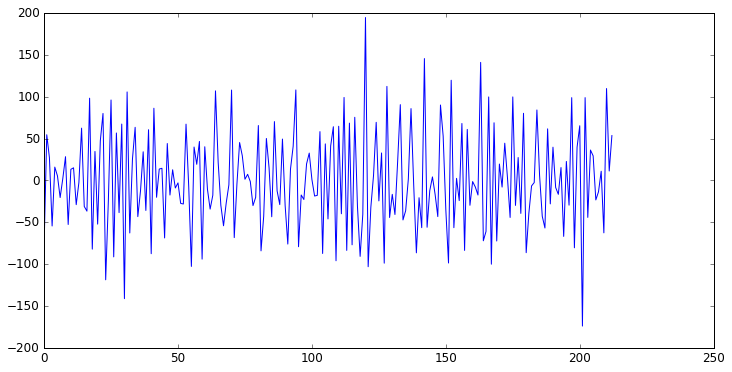

In [25]:
plt.plot(d_prcp)
plt.axhline(y= mean_d_prcp, color= 'r')
mean_d_prcp = np.mean(d_prcp)
print('Durchschnittliche Abweichung', mean_d_prcp)
max_d_prcp = np.amax(d_prcp)
print('Maximale Abweichung:',max_d_prcp )
std_d_prcp = np.std(d_prcp)
print('Standardabweichung:', std_d_prcp)

Now we plot the temperature/prcp sorted by values

In [26]:
#Abweichung von der Mittel Temperatur berechnen und aufsteigend sortieren
temp_sorted = np.sort(annual_tlist)
d_temp_mean = temp_sorted - mean_d_temp



In [27]:
#Abweichung von der Mittel Temperatur berechnen und aufsteigend sortieren (Niederschlag)
prcp_sorted = np.sort(annual_plist)
d_prcp_mean = prcp_sorted - mean_d_prcp


NameError: name 'mean_d_prcp' is not defined

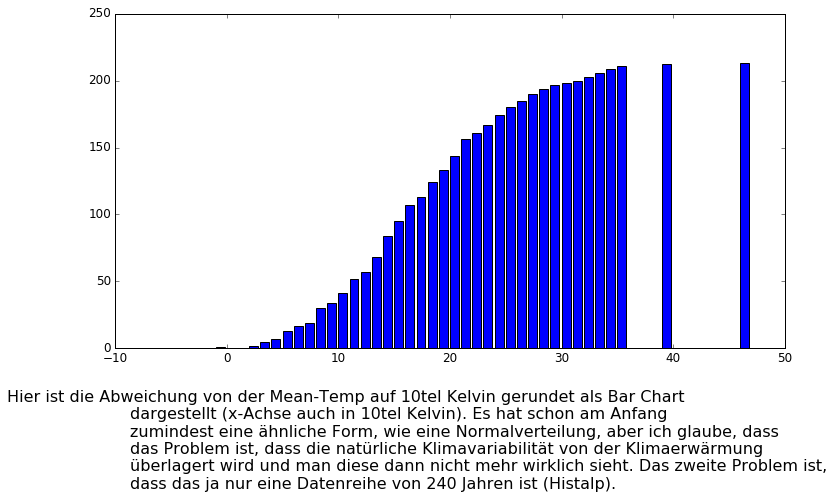

In [28]:
d_temp_mean_round = np.around(d_temp_mean, decimals=1)
tmp = d_temp_mean_round *10
N = range(len(tmp))

fig = plt.figure()
plt.bar(tmp, N)
fig.text(0, -0.2, r'''Hier ist die Abweichung von der Mean-Temp auf 10tel Kelvin gerundet als Bar Chart
                        dargestellt (x-Achse auch in 10tel Kelvin). Es hat schon am Anfang
                        zumindest eine ähnliche Form, wie eine Normalverteilung, aber ich glaube, dass
                        das Problem ist, dass die natürliche Klimavariabilität von der Klimaerwärmung
                        überlagert wird und man diese dann nicht mehr wirklich sieht. Das zweite Problem ist,
                        dass das ja nur eine Datenreihe von 240 Jahren ist (Histalp). ''', fontsize=16)

In [ ]:
d_prcp_mean_round = np.around(d_prcp_mean, decimals=-1)
tmp2 = d_prcp_mean_round
N2 = range(len(tmp))

fig = plt.figure()
plt.bar(tmp2, N2)
fig.text(0, -0.05, r'''Das gleiche Nochmal für Niederschlag (jetzt auf die erste Stelle gerundet) ''', fontsize=16)

### Milchbach Caves
Now we look specifically at the Grid point closest to the Milchbach Caves. The intention is to find out which climate induces what change in height at the milchbach cave system. 

In [16]:
#np.size(mb_mod.heights)
#model.run_until_equilibrium()

#Get the runtime until equilibrium of the model
y_0 = 1.

                      
#Initialize Model and let it run without bias for reference
mb_mod = massbalance.BiasedMassBalanceModel(gdir)
mb_mod.set_prcp_factor(1)
mb_mod.set_temp_bias(0)
model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=0, 
                                fs=0., glen_a=glen_a)

    
model.run_until_equilibrium()
runtime_eq = model.yr
vol_eq = model.volume_km3
length_eq = model.length_m



In [46]:
#Define a random climate
nyrs = 1000
mean_t = 0
sigma_t = 1
bias_t = np.random.normal(mean_t, sigma_t, nyrs)

mean_p = 1
sigma_p = 0.3
bias_p = np.random.normal(mean_p, sigma_p, nyrs)


length = np.zeros(nyrs)
vol = np.zeros(nyrs)
tau = np.zeros(nyrs)

for i in range(0, nyrs):
    t_bias = bias_t[i]
    p_bias = bias_p[i]
    mb_mod.set_temp_bias(t_bias)
    mb_mod.set_prcp_factor(p_bias)
    model.run_until(i + runtime_eq)
    length[i] = model.length_m
    vol[i] = model.volume_km3
    tau[i] = model.yr

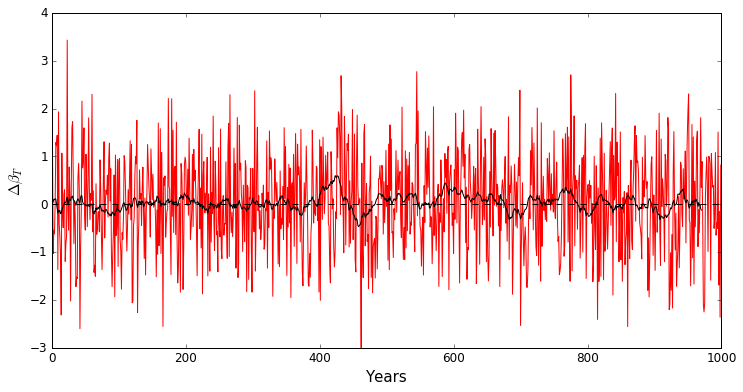

In [47]:
N = 30
mean_30_t = np.convolve(bias_t, np.ones((N,))/N, mode='valid')

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
plt.plot(bias_t, 'r')
plt.plot(mean_30_t, color='black')
plt.ylabel('$\Delta \\beta_T$', fontsize=15)
plt.xlabel('Years', fontsize=15)
plt.axhline(y= 0, color= 'black', ls='dashed')



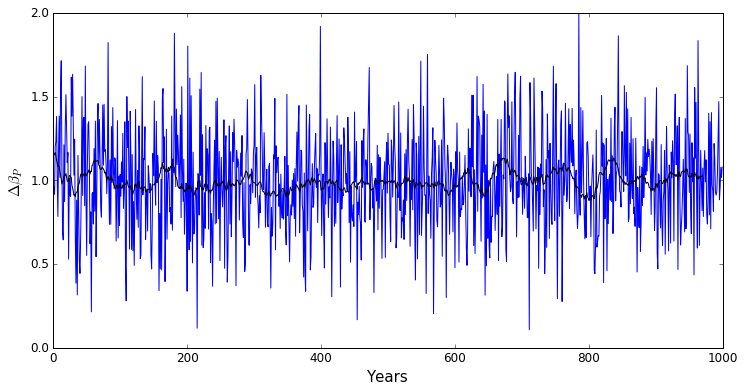

In [48]:
N = 30
mean_30_p = np.convolve(bias_p, np.ones((N,))/N, mode='valid')

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
plt.plot(bias_p, 'b')
plt.plot(mean_30_p, color='black')
plt.ylabel('$\Delta \\beta_P$', fontsize=15)
plt.xlabel('Years', fontsize=15)
plt.axhline(y= 0, color= 'black', ls='dashed')



0.491078286071


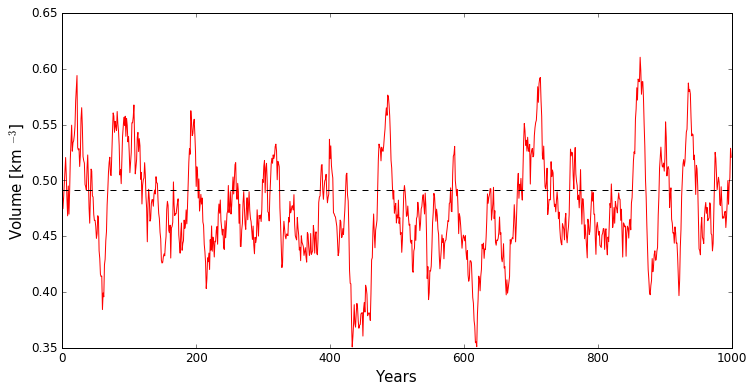

In [59]:
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
plt.plot(vol, color='red')
plt.ylabel('Volume [km $^{-3}$]', fontsize=15)
plt.xlabel('Years', fontsize=15)
plt.axhline(y= vol_eq, color= 'black', ls='dashed')

print(vol_eq)

4048.0


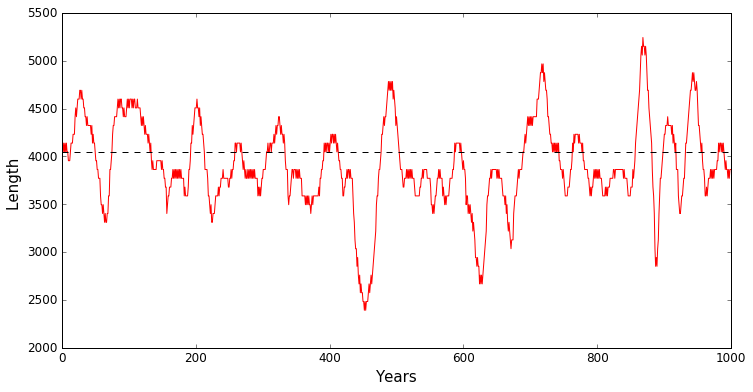

In [61]:
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
plt.plot(length, color='red')
plt.ylabel('Length ', fontsize=15)
plt.xlabel('Years', fontsize=15)
plt.axhline(y= length_eq, color= 'black', ls='dashed')

print(length_eq)

### Now the heigth at the cave 

In [17]:
def calc_height(bed_shape, width):
    return bed_shape*width**2/4

In [18]:
#t_bias=[-3.5]
#pr_f=[1.6]
t_bias = [-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1]
#t_bias = np.linspace(-3, 4, 3)
pr_f = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
#pr_f = np.linspace(0, 2.8, 61)

s_t_bias = np.size(t_bias)
s_pr_f = np.size(pr_f)

length_temp = np.linspace(0, 127, 128)
heights_46 = np.zeros((s_t_bias, s_pr_f))
heights_47 = np.zeros((s_t_bias, s_pr_f))
heights_48 = np.zeros((s_t_bias, s_pr_f))

i= -1
j= -1
k=-1
#height_cave = np   
mb_mod = massbalance.BiasedMassBalanceModel(gdir)

heights_all = np.zeros((130, s_t_bias*s_pr_f))

for b in t_bias:
    j=-1
    i=i+1
    #mb_mod.set_temp_bias(b)
    for f in pr_f:
        j = j+1
        k = k+1
        mb_mod.set_temp_bias(b)
        mb_mod.set_prcp_factor(f)
        model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=0, 
                                fs=0., glen_a=glen_a)
        model.run_until_equilibrium()
        fl = model.fls[0]
        heights_46[i][j] = fl.surface_h[46]
        heights_47[i][j] = fl.surface_h[47]
        heights_48[i][j] = fl.surface_h[48]
        for r in length_temp:
            heights_all[0][k] = b
            heights_all[1][k] = f 
            heights_all[r+2][k] =fl.surface_h[r]
        #print('temp', b)
        #print("prcp", f)
        #print(fl.surface_h[51])
        

/home/thomas/anaconda2/envs/oggm_env/lib/python3.5/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


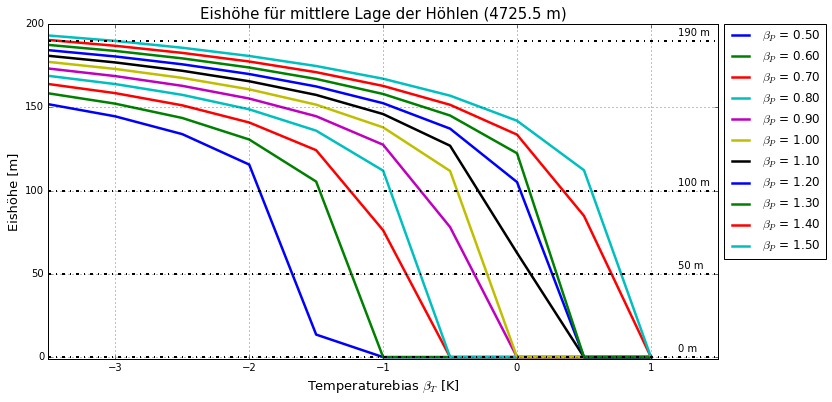

In [70]:
#Grid 48
cave_height= [1650, 1700, 1750, 1840]
cave_height_new = [0, 50, 100, 190]
la = -1

heights_46_new = heights_46 -fl.bed_h[46]
heights_47_new = heights_47 - fl.bed_h[47]
heights_48_new = heights_48 - fl.bed_h[48]

heights_inter = heights_47_new*(1-0.2555) + heights_47_new*0.2555
for u in pr_f:
    la= la +1
    plt.plot(t_bias, heights_inter[:,la], linewidth=2.5, label= '$\\beta_P$ = %.2f' %u)
    plt.ylabel('Eishöhe [m]', fontsize = 13)
    plt.xlabel('Temperaturebias $\\beta_T$ [K]', fontsize = 13)
    plt.legend()
    plt.legend(bbox_to_anchor=(1.17, 1.019))
    plt.ylim(-1, 200)
    plt.xlim(-3.5, 1.5)
    
for i in cave_height_new:
    plt.axhline(y = i, linestyle = 'dashdot', linewidth = 2, color = 'Black')
    plt.text(1.2, i+3, '%d m' %i, fontsize = 10)

plt.gca().yaxis.grid(True)
plt.grid(True)
plt.title('Eishöhe für mittlere Lage der Höhlen (4725.5 m)', fontsize = 15)


In [14]:
#t_bias=[-3.5]
#pr_f=[1.6]
t_bias = [-3.5, -3, -2.5, -2, -1.5,-1, -0.5, 0, 0.5, 1]
#t_bias = np.linspace(-3, 4, 3)
pr_f = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
#pr_f = np.linspace(0, 2.8, 61)

s_t_bias = np.size(t_bias)
s_pr_f = np.size(pr_f)

length_temp = np.linspace(0, 127, 128)
heights_46 = np.zeros((s_t_bias, s_pr_f))
heights_47 = np.zeros((s_t_bias, s_pr_f))
heights_48 = np.zeros((s_t_bias, s_pr_f))
i= -1
j= -1
k=-1
#height_cave = np   
mb_mod = massbalance.BiasedMassBalanceModel(gdir)

heights_all = np.zeros((130, s_t_bias*s_pr_f))

for b in t_bias:
    j=-1
    i=i+1
    #mb_mod.set_temp_bias(b)
    for f in pr_f:
        j = j+1
        k = k+1
        mb_mod.set_temp_bias(b)
        mb_mod.set_prcp_factor(f)
        model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=0, 
                                fs=0., glen_a=glen_a)
        model.run_until_equilibrium()
        fl = model.fls[0]
        heights_46[i][j] = fl.surface_h[47]
        heights_47[i][j] = fl.surface_h[47]
        heights_48[i][j] = fl.surface_h[48]
        for r in length_temp:
            heights_all[0][k] = b
            heights_all[1][k] = f 
            heights_all[r+2][k] =fl.surface_h[r]
            #temperature
        #print('temp', b)
        #print("prcp", f)
        #print(fl.surface_h[51])
        

/home/thomas/anaconda2/envs/oggm_env/lib/python3.5/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [26]:
heights_all_new = np.zeros((130, s_t_bias*s_pr_f))
heights_all_new = heights_all
r=1
range_j = s_t_bias*s_pr_f

for i in range(130):
    r = r+1
    for j in range(range_j):
        if r <130:
            heights_all_new[r][j] = heights_all[r][j] - fl.bed_h[i]
    


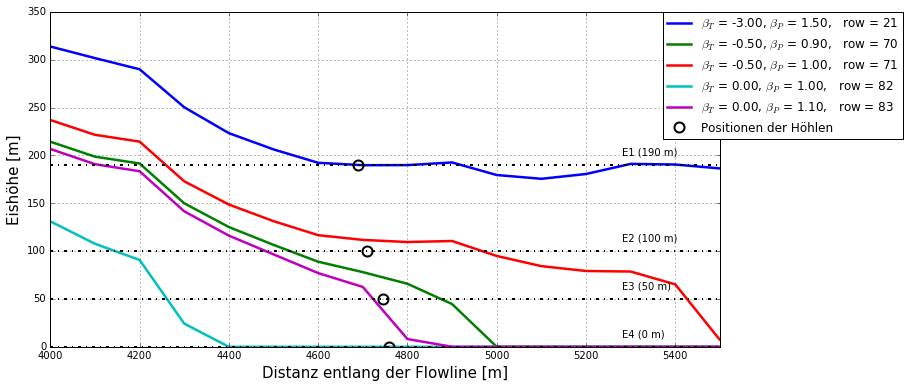

In [63]:
dista=100
cave_height_new = [0, 50, 100, 190]
cave_x = [4689, 4710, 4744.8, 4758.4]
cave_y = [190, 100, 50, 0]
x = np.linspace(0, 127, 128)*dista
l= 4

rows = [21, 70, 71, 82, 83]
#rows =np.linspace(240,252,7)
for r in rows:
    plt.plot(x, heights_all_new[2:,r], linewidth=2.5, 
             label='$ \\beta_T$ = %.2f, $ \\beta_P$ = %.2f,   row = %d' %(heights_all[0][r], heights_all[1][r], r))


plt.xlabel('Distanz entlang der Flowline [m]', fontsize = 15)
plt.ylabel('Eishöhe [m]', fontsize = 15)
plt.xlim(40*dista, 55*dista)
#plt.ylim(-10, 300)

for i in cave_height_new:
    plt.axhline(y = i, linestyle = 'dashdot', color = 'Black', linewidth = 2)
    plt.text(52.8*dista, i+10, 'E%d (%d m)' %(l,i))
    l = l -1 
    
plt.plot(cave_x, cave_y, linestyle='none',  marker='o', markersize=10, color='none',
         markeredgecolor='k', markeredgewidth=2, label = 'Positionen der Höhlen')


plt.gca().yaxis.grid(True)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.283, 1.019), numpoints=1)

In [23]:
cave_x = [47.548, 47.448, 47.1, 46.89]
cave_height= [1650, 1700, 1750, 1840]
cave_height_new = [0, 50, 100, 190]
size = len(heights_all[0,:])

height_e1 = np.zeros((3, size))
abstand_e1 = np.zeros((3, size))
height_e2 = np.zeros((3, size))
abstand_e2 = np.zeros((3, size))
height_e3 = np.zeros((3, size))
abstand_e3 = np.zeros((3, size))
height_e4 = np.zeros((3, size))
abstand_e4 = np.zeros((3, size))

for i in range(size):
    height_e1[0][i] = heights_all_new[0][i]
    height_e1[1][i] = heights_all_new[1][i]
    
    height_e2[0][i] = heights_all_new[0][i]
    height_e2[1][i] = heights_all_new[1][i]
    
    height_e3[0][i] = heights_all_new[0][i]
    height_e3[1][i] = heights_all_new[1][i]
    
    height_e4[0][i] = heights_all_new[0][i]
    height_e4[1][i] = heights_all_new[1][i]
    
    
    
abstand_e1 = height_e1
abstand_e2 = height_e2
abstand_e3 = height_e3
abstand_e4 = height_e4

for j in range(size):
    height_e1[2][j] = heights_all_new[48][j]*(1-0.89) + heights_all_new[49][j]*0.89
    abstand_e1[2][j] = height_e1[2][j] - 190
    height_e2[2][j] = heights_all_new[49][j]*(1-0.1) + heights_all_new[50][j]*0.1
    abstand_e2[2][j] = height_e2[2][j] - 100
    height_e3[2][j] = heights_all_new[49][j]*(1-0.448) + heights_all_new[50][j]*0.448
    abstand_e3[2][j] = height_e3[2][j] - 50
    height_e4[2][j] = heights_all_new[49][j]*(1-0.584) + heights_all_new[50][j]*0.584
    abstand_e4[2][j] = height_e4[2][j] -1
   

        
for l in range(size):
    if abstand_e1[2][l] < 0:
        print('Temp = %.2f und Prcp = %.2f --> E1 OFFEN' %(abstand_e1[0][l], abstand_e1[1][l]))
    elif abstand_e1[2][l] >= 0:
        print('Temp = %.2f und Prcp = %.2f --> E1 ZU' %(abstand_e1[0][l], abstand_e1[1][l]))
    else:
        print('Temp = %.2f und Prcp = %.2f --> FATAL ERROR' %(abstand_e1[0][l], abstand_e1[1][l]))
        
print('\n')

for l in range(size):
    if abstand_e2[2][l] < 0:
        print('Temp = %.2f und Prcp = %.2f --> E2 OFFEN' %(abstand_e2[0][l], abstand_e2[1][l]))
    elif abstand_e2[2][l] >= 0:
        print('Temp = %.2f und Prcp = %.2f --> E2 ZU' %(abstand_e2[0][l], abstand_e2[1][l]))
    else:
        print('Temp = %.2f und Prcp = %.2f --> FATAL ERROR' %(abstand_e2[0][l], abstand_e2[1][l]))
    
    
print('\n')

for l in range(size):
    if abstand_e3[2][l] < 0:
        print('Temp = %.2f und Prcp = %.2f --> E3 OFFEN' %(abstand_e3[0][l], abstand_e3[1][l]))
    elif abstand_e3[2][l] >= 0:
        print('Temp = %.2f und Prcp = %.2f --> E3 ZU' %(abstand_e3[0][l], abstand_e3[1][l]))
    else:
        print('Temp = %.2f und Prcp = %.2f --> FATAL ERROR' %(abstand_e3[0][l], abstand_e3[1][l]))
        
print('\n')

for l in range(size):
    if abstand_e4[2][l] < 0:
        print('Temp = %.2f und Prcp = %.2f --> E4 OFFEN' %(abstand_e3[0][l], abstand_e3[1][l]))
    elif z_e4[2][l] >= 1:
        print('Temp = %.2f und Prcp = %.2f --> E4 ZU' %(abstand_e4[0][l], abstand_e4[1][l]))
    else:
        print('Temp = %.2f und Prcp = %.2f --> FATAL ERROR' %(abstand_e3[0][l], abstand_e3[1][l]))

Temp = -3.50 und Prcp = 0.50 --> E1 OFFEN
Temp = -3.50 und Prcp = 0.60 --> E1 OFFEN
Temp = -3.50 und Prcp = 0.70 --> E1 OFFEN
Temp = -3.50 und Prcp = 0.80 --> E1 OFFEN
Temp = -3.50 und Prcp = 0.90 --> E1 OFFEN
Temp = -3.50 und Prcp = 1.00 --> E1 OFFEN
Temp = -3.50 und Prcp = 1.10 --> E1 OFFEN
Temp = -3.50 und Prcp = 1.20 --> E1 OFFEN
Temp = -3.50 und Prcp = 1.30 --> E1 OFFEN
Temp = -3.50 und Prcp = 1.40 --> E1 ZU
Temp = -3.50 und Prcp = 1.50 --> E1 ZU
Temp = -3.00 und Prcp = 0.50 --> E1 OFFEN
Temp = -3.00 und Prcp = 0.60 --> E1 OFFEN
Temp = -3.00 und Prcp = 0.70 --> E1 OFFEN
Temp = -3.00 und Prcp = 0.80 --> E1 OFFEN
Temp = -3.00 und Prcp = 0.90 --> E1 OFFEN
Temp = -3.00 und Prcp = 1.00 --> E1 OFFEN
Temp = -3.00 und Prcp = 1.10 --> E1 OFFEN
Temp = -3.00 und Prcp = 1.20 --> E1 OFFEN
Temp = -3.00 und Prcp = 1.30 --> E1 OFFEN
Temp = -3.00 und Prcp = 1.40 --> E1 OFFEN
Temp = -3.00 und Prcp = 1.50 --> E1 ZU
Temp = -2.50 und Prcp = 0.50 --> E1 OFFEN
Temp = -2.50 und Prcp = 0.60 --> E1 OFFEN
T

NameError: name 'z_e4' is not defined

## COLORBAR

In [ ]:

t_bias = np.linspace(-3.5, 1, 46)
pr_f = np.linspace(0.5, 1.5, 21)

s_t_bias = np.size(t_bias)
s_pr_f = np.size(pr_f)

length_temp = np.linspace(0, 127, 128)
heights_46 = np.zeros((s_pr_f, s_t_bias))
heights_47 = np.zeros((s_pr_f, s_t_bias))
heights_48 = np.zeros((s_pr_f, s_t_bias))

i= -1
j= -1
k=-1
#height_cave = np   
mb_mod = massbalance.BiasedMassBalanceModel(gdir)

heights_all = np.zeros((130, s_t_bias*s_pr_f))

for b in t_bias:
    j=-1
    i=i+1
    #mb_mod.set_temp_bias(b)
    for f in pr_f:
        j = j+1
        k = k+1
        mb_mod.set_temp_bias(b)
        mb_mod.set_prcp_factor(f)
        model = flowline.FluxBasedModel([copy.deepcopy(u_fl)], 
                                mb_model=mb_mod, y0=0, 
                                fs=0., glen_a=glen_a)
        model.run_until_equilibrium()
        fl = model.fls[0]
        heights_46[j][i] = fl.surface_h[47]
        heights_47[j][i] = fl.surface_h[47]
        heights_48[j][i] = fl.surface_h[48]
        for r in length_temp:
            heights_all[0][k] = b
            heights_all[1][k] = f 
            heights_all[r+2][k] =fl.surface_h[r]
            #temperature
        #print('temp', b)
        #print("prcp", f)
        #print(fl.surface_h[51])
        

/home/thomas/anaconda2/envs/oggm_env/lib/python3.5/site-packages/ipykernel/__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [48]:
heights_all_new = np.zeros((130, s_t_bias*s_pr_f))
heights_all_new = heights_all
r=1
range_j = s_t_bias*s_pr_f

for i in range(130):
    r = r+1
    for j in range(range_j):
        if r <130:
            heights_all_new[r][j] = heights_all[r][j] - fl.bed_h[i]
    


In [61]:
heights_46_new = heights_46 - fl.bed_h[46]
heights_47_new = heights_47 - fl.bed_h[47]
heights_48_new = heights_48 - fl.bed_h[46]

abstand_e1 = (heights_46_new *(1-0.89) + heights_47_new*0.89)-190
abstand_e2 = (heights_47_new *(1-0.1) + heights_48_new*0.1)-100
abstand_e3 = (heights_47_new *(1-0.448) + heights_48_new*0.448)-50
abstand_e2 = (heights_47_new *(1-0.584) + heights_48_new*0.584)

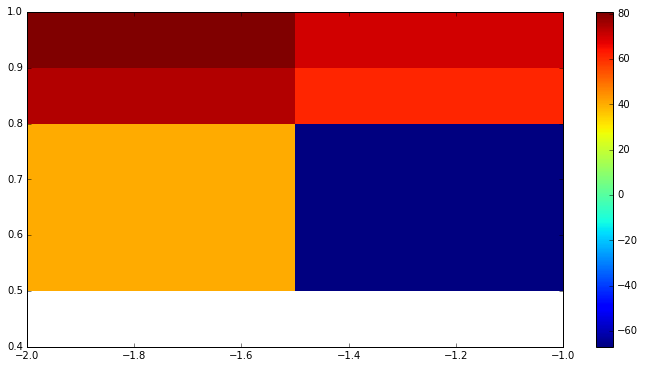

In [62]:
py.pcolor(t_bias, pr_f, abstand_e3)
py.colorbar()
py.show()

In [76]:
t_bias = np.linspace(-3.5, 1, 46)
pr_f = np.linspace(0.5, 1.5, 21)

In [75]:
test_pr_f

array([ 0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,  1.35,
        1.4 ,  1.45,  1.5 ])